In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

tf.device('/gpu:0')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=40

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory('/kaggle/input/plantvillage/PlantVillage', shuffle=True,image_size=(IMAGE_SIZE,IMAGE_SIZE), batch_size=BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names

In [5]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

In [7]:
32*68

2176

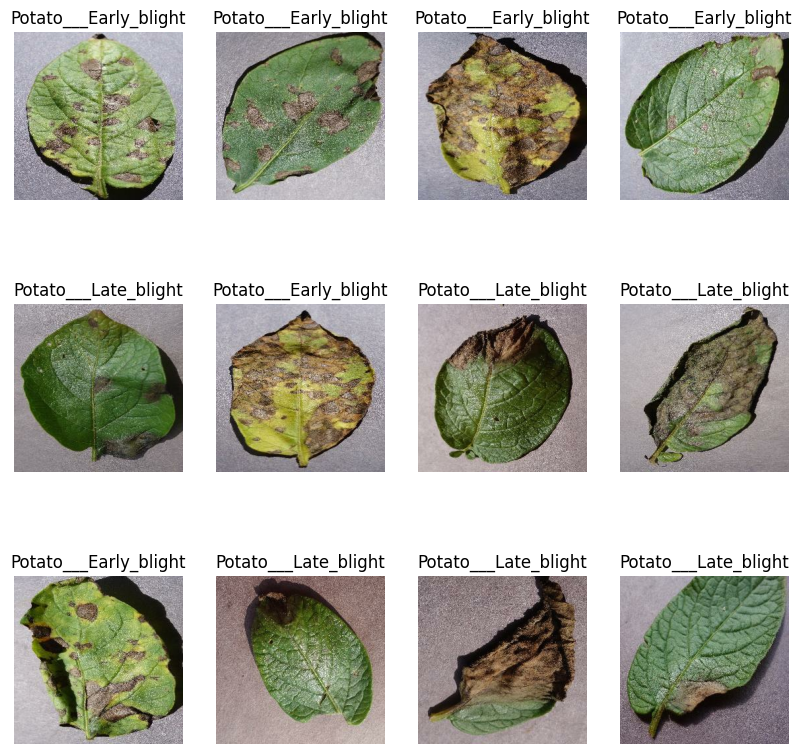

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("Off")

20% test size

10% validation 10% test

In [9]:
def train_test_split(ds, train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True,  shuffle_size=10000):
    ds_len = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, 12)
    train_len = int(train_split*ds_len)
    val_len = int(val_split*ds_len)
    test_len = ds_len - train_len - val_len
    
    train_ds = dataset.take(train_len)
    val_ds = dataset.skip(train_len).take(val_len)
    test_ds = dataset.skip(ds_len - test_len)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = train_test_split(dataset)

In [11]:
len(test_ds)

8

In [12]:
# caching the dataset
train_ds = train_ds.cache().shuffle(512).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(512).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(512).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [15]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu', input_shape =input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu' ),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128,(3,3), activation='relu' ),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu' ),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu' ),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(32,(3,3), activation='relu' ),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(32,activation='relu'),
    layers.Dense(len(class_names), activation='softmax'),
    
])
model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    train_ds, epochs=EPOCHS, batch_size=BATCH_SIZE,  validation_data=val_ds
)

Epoch 1/40
54/54 [==============================] - 17s 73ms/step - loss: 0.9181 - accuracy: 0.4560 - val_loss: 0.8766 - val_accuracy: 0.5573
Epoch 2/40
54/54 [==============================] - 2s 42ms/step - loss: 0.6755 - accuracy: 0.6950 - val_loss: 0.4623 - val_accuracy: 0.7812
Epoch 3/40
54/54 [==============================] - 2s 42ms/step - loss: 0.4260 - accuracy: 0.8206 - val_loss: 0.5232 - val_accuracy: 0.7188
Epoch 4/40
54/54 [==============================] - 2s 42ms/step - loss: 0.3415 - accuracy: 0.8542 - val_loss: 0.2643 - val_accuracy: 0.8906
Epoch 5/40
54/54 [==============================] - 2s 42ms/step - loss: 0.3918 - accuracy: 0.8513 - val_loss: 0.3709 - val_accuracy: 0.9010
Epoch 6/40
54/54 [==============================] - 2s 42ms/step - loss: 0.2935 - accuracy: 0.8912 - val_loss: 0.2346 - val_accuracy: 0.8906
Epoch 7/40
54/54 [==============================] - 2s 42ms/step - loss: 0.1862 - accuracy: 0.9219 - val_loss: 0.3161 - val_accuracy: 0.8698
Epoch 8/40
5

In [19]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 38ms/step - loss: 0.0503 - accuracy: 0.9784


In [20]:
scores

[0.050333086401224136, 0.9784482717514038]

In [21]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


In [23]:
import numpy as np
np.shape(val_acc)

(40,)

Text(0.5, 1.0, 'Training and Validation Loss')

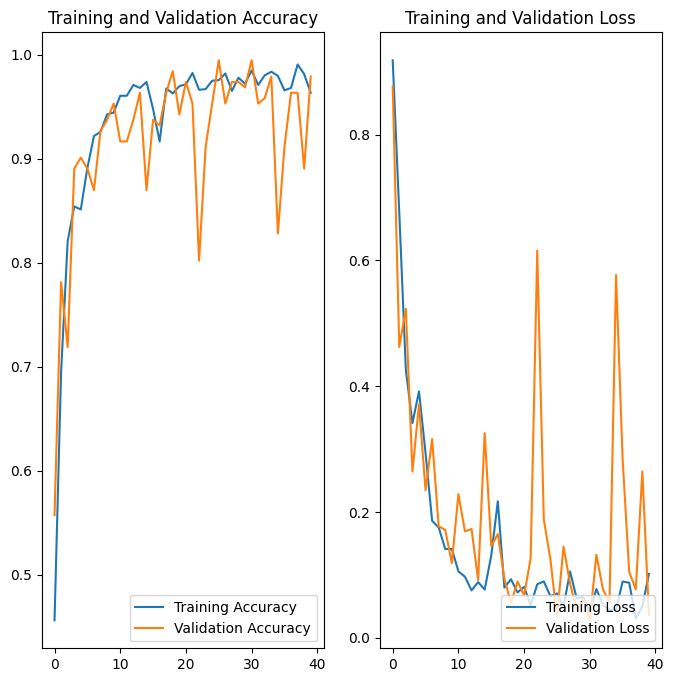

In [24]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')



In [25]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print(class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print(class_names[np.argmax(batch_prediction[0])])

Potato___Late_blight
1/1 [==============================] - 0s 172ms/step
Potato___Late_blight


In [26]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 22ms/step


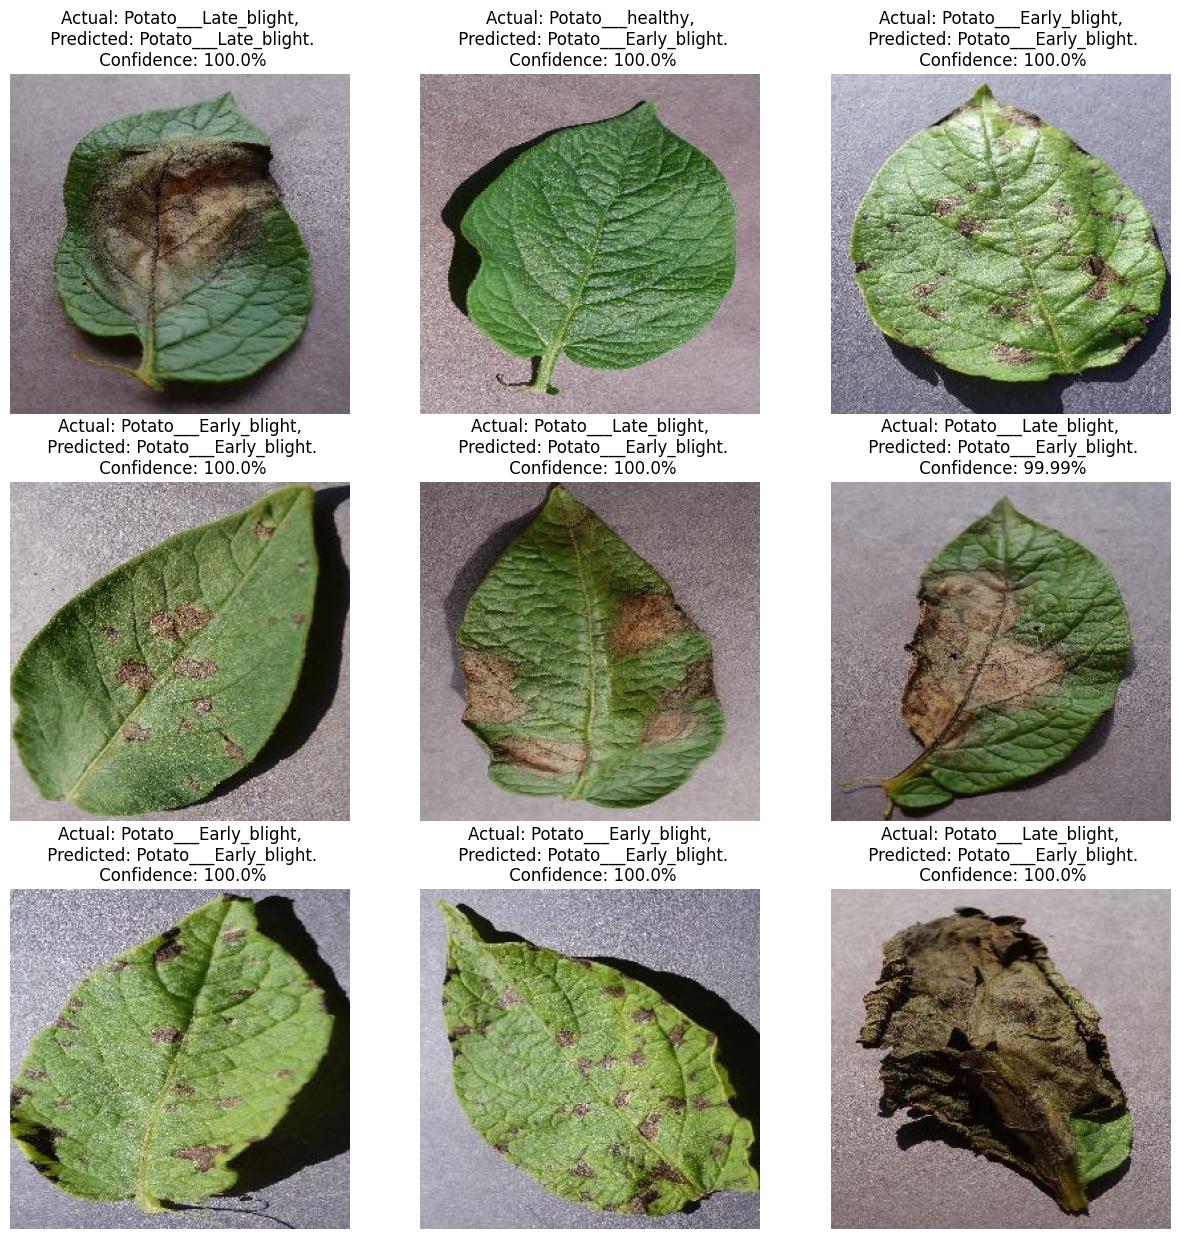

In [27]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


In [28]:
import os
if not os.path.exists('./models'):
    os.makedirs('./models')
model_version=max([int(i) for i in os.listdir("./models") + [0]])+1
model.save(f"./models/{model_version}")

In [29]:
model.save("./potatoes.h5")